In [1]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import AutoEncoder, train_model, CombinedLoss
from torch.optim import Adam

# Data Loading

In [2]:
# load data from s3 storage
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,…,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_responder_0_lagged,feature_responder_1_lagged,feature_responder_2_lagged,feature_responder_3_lagged,feature_responder_4_lagged,feature_responder_5_lagged,feature_responder_6_lagged,feature_responder_7_lagged,feature_responder_8_lagged,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,symbol_id,time_id,weight
i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,f32
0,0.127298,0.339121,-0.045494,0.151473,-0.038995,-0.644192,-0.193971,-0.016662,-0.213108,-0.045016,0.014899,0.128033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.397016,0.694868,0.812098,-0.128621,0.025559,0.018694,-0.006306,-1.706433,-0.490941,0.425017,0.281025,-0.134582,0.046605,-0.059343,-0.751958,-0.314242,…,0.085259,-0.324355,-0.097414,-0.296044,0.21344,-0.20025,-0.11987,-0.007101,-0.693186,-0.181427,0.073886,-0.062266,0.136151,0.110356,0.055748,-0.028266,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,1,35,3.889038
0,0.114208,-1.419921,-0.505525,-0.258195,0.017889,-0.254385,0.015691,-0.020583,-0.15111,-0.034961,-0.045215,-0.411787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037745,-0.824408,-0.312367,0.272155,0.041673,0.051002,0.101001,-0.172871,0.356697,0.43781,-0.243426,0.116691,0.21925,-0.059218,-0.298613,0.029315,…,-0.067586,0.22172,0.347892,0.511532,-0.214167,-0.045423,-0.048534,0.048807,-0.407794,0.008081,-0.071584,0.056597,0.01653,-0.049644,-0.023103,-0.0531,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,1,36,3.889038
0,0.118826,-1.293755,-0.809856,0.268584,-0.056675,-0.273341,-0.016404,0.010669,0.172457,0.011381,0.013246,-0.016248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571682,0.168574,-0.042331,-0.55658,0.175519,-0.052067,0.053939,0.109843,-0.055707,-0.214608,-0.026042,-0.180718,-0.171372,-0.019658,-0.084493,-0.116301,…,-0.100162,-0.029472,0.037072,0.097566,0.061552,-0.136708,-0.029742,-0.047774,-0.150518,-0.287006,-0.000054,-0.048201,-0.093462,-0.015866,0.051347,0.055587,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,1,37,3.889038
0,-0.216346,-0.021069,-0.425764,-0.005701,-0.010654,0.302838,0.000491,-0.017648,-0.036415,-0.008958,0.384812,0.49453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.202302,0.395804,-0.512155,0.642004,0.414221,0.113961,-0.131998,-0.374575,0.206433,-0.445924,-0.518108,0.268771,0.069906,0.207732,-0.046667,-0.266864,…,0.036929,-0.176699,-0.503255,-0.449954,-0.134894,0.050516,-0.089379,0.004014,-0.204778,-0.144482,-0.082102,-0.050271,0.020269,-0.008658,0.096835,-0.042524,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,0.423799,-0.195033,0.145029,-0.076218,-0.304814,0.098249,-0.606483,-0.01076,-0.134628,1,38,3.889038
0,-0.660073,2.168059,0.903407,-0.101644,0.133174,-0.212203,-0.217244,0.006182,-0.076704,-0.027879,0.249095,-0.431726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511043,-0.221639,-0.014473,-0.

In [3]:
# we pick responder_6 as the target (same target as the data challenge)
target = "responder_6"
features = [col for col in data.columns if "feature" in col]

X, y = data[features], data[target]

# we do a 80/20 temporal split
n = X.height
n_train = int(0.8 * n)
X_train = X.slice(0, n_train)
y_train = y.slice(0, n_train)

X_val = X.slice(n_train)
y_val = y.slice(n_train)

# define a class for datasets
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        if y.ndim == 1:
            y = y.view(-1, 1)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

train_data_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, num_workers=8)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

# Model Evaluation

 10%|█         | 1/10 [00:08<01:17,  8.65s/it]

Epoch 01 | loss=138.495 | R2_rec_train=-0.3651 | R2_rec_val=-2.9596 | R2_sup_train=0.7481 | R2_sup_val=0.5359


 20%|██        | 2/10 [00:17<01:09,  8.73s/it]

Epoch 02 | loss=107.641 | R2_rec_train=0.1422 | R2_rec_val=0.0269 | R2_sup_train=0.8196 | R2_sup_val=0.7533


 30%|███       | 3/10 [00:25<00:58,  8.41s/it]

Epoch 03 | loss=105.011 | R2_rec_train=0.1164 | R2_rec_val=-0.2596 | R2_sup_train=0.8249 | R2_sup_val=0.7908


 40%|████      | 4/10 [00:34<00:51,  8.65s/it]

Epoch 04 | loss=101.564 | R2_rec_train=0.0176 | R2_rec_val=-1.1120 | R2_sup_train=0.8258 | R2_sup_val=0.8309


 50%|█████     | 5/10 [00:42<00:42,  8.45s/it]

Epoch 05 | loss=97.550 | R2_rec_train=-0.0336 | R2_rec_val=0.0760 | R2_sup_train=0.8294 | R2_sup_val=0.8374


 60%|██████    | 6/10 [00:50<00:33,  8.35s/it]

Epoch 06 | loss=95.938 | R2_rec_train=0.2130 | R2_rec_val=-0.2381 | R2_sup_train=0.8308 | R2_sup_val=0.8350


 70%|███████   | 7/10 [00:58<00:24,  8.21s/it]

Epoch 07 | loss=97.692 | R2_rec_train=0.1644 | R2_rec_val=-0.2469 | R2_sup_train=0.8284 | R2_sup_val=0.8268


 80%|████████  | 8/10 [01:05<00:15,  7.82s/it]

Epoch 08 | loss=96.177 | R2_rec_train=0.0894 | R2_rec_val=-0.9471 | R2_sup_train=0.8320 | R2_sup_val=0.8423


 90%|█████████ | 9/10 [01:12<00:07,  7.49s/it]

Epoch 09 | loss=95.767 | R2_rec_train=0.0894 | R2_rec_val=-0.8721 | R2_sup_train=0.8318 | R2_sup_val=0.8415


100%|██████████| 10/10 [01:20<00:00,  8.04s/it]

Epoch 10 | loss=92.770 | R2_rec_train=0.1651 | R2_rec_val=-0.6182 | R2_sup_train=0.8323 | R2_sup_val=0.8403


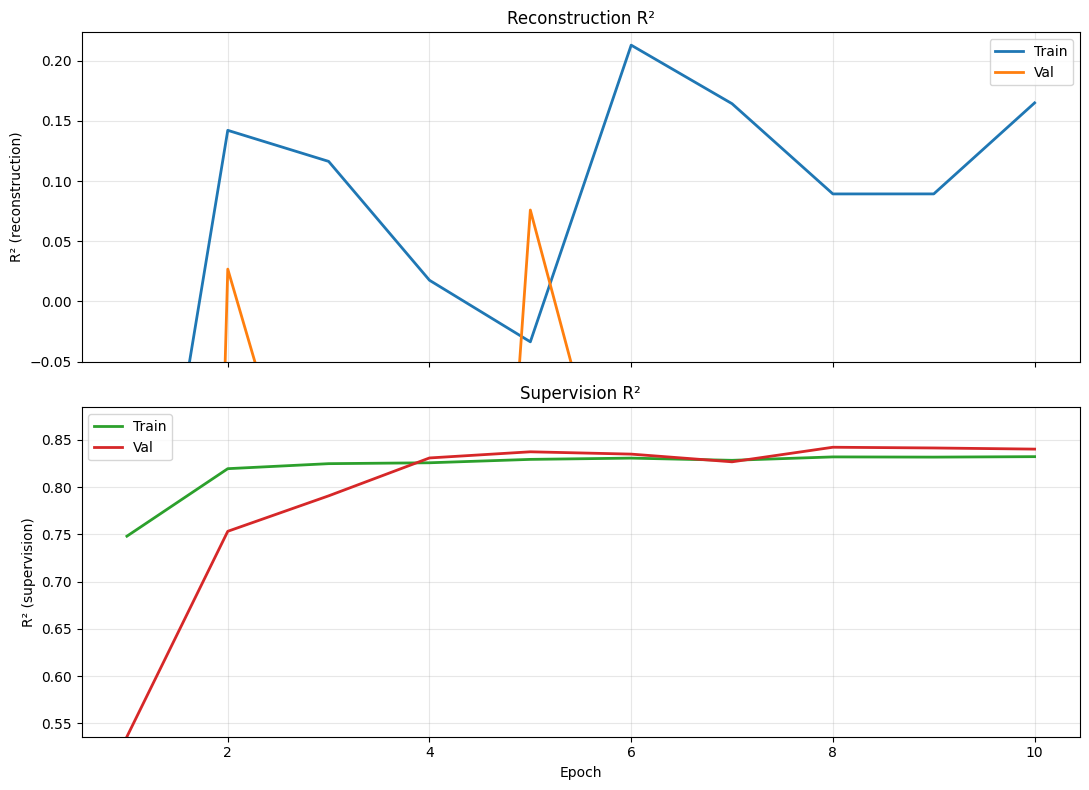

In [4]:
# define model
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 8, 4]

model = AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
)

# define optimization parameters
lr = 1e-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha = 1.0
beta = 1.0

optimizer = Adam(model.parameters(), lr=lr)
criterion = CombinedLoss(alpha=alpha, beta=beta)
n_epochs = 10

train = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
)

# Result analysis

- Supervision task reaches a plateau around 84%
- Reconstruction is unstable
- Let's try other parameters